In [71]:
import numpy as np
import matplotlib.pyplot as plt

import d3s.domain as domain
import d3s.observables as observables
import d3s.algorithms as algorithms
import d3s.systems as systems
import scipy as _sp
from typing import NewType

KoopmanMatrix         = NewType("KoopmanMatrix", np.ndarray)
Vector                = NewType("Vector", np.ndarray)
MonomialObservable    = NewType("MonomialObservable", observables.monomials)
Matrix                = NewType("Matrix", np.ndarray)

np.random.seed(seed=233423)

def edmd(PsiX, PsiY, psi, evs=5):
    '''
    Conventional EDMD for the Koopman or Perron-Frobenius operator. The matrices X and Y
    contain the input data.

    :param psi:      set of basis functions, see d3s.observables
    :param evs:      number of eigenvalues/eigenvectors
    :param operator: 'K' for Koopman or 'P' for Perron-Frobenius
    :return:         eigenvalues d and corresponding eigenvectors V containing the coefficients for the eigenfunctions
    '''
    C_0 = PsiX @ PsiX.T
    C_1 = PsiY @ PsiX.T
    #pesudo-inverse: X.T @ (X @ X.T)^-1
    A = C_1 @ np.linalg.pinv(C_0)
    d, V = sortEig(A, evs)
    return (A, d, V)

def gEDMD(X, Y, Z, psi):
    
    PsiX = psi(X)
    dPsiY = np.einsum('ijk,jk->ik', psi.diff(X), Y)
    
    if not (Z is None): # stochastic dynamical system
        n = PsiX.shape[0] # number of basis functions
        ddPsiX = psi.ddiff(X) # second-order derivatives
        S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T
        for i in range(n):
            dPsiY[i, :] += 0.5*np.sum( ddPsiX[i, :, :, :] * S, axis=(0,1) )
    
    C_0 = PsiX @ PsiX.T
    C_1 = dPsiY @ PsiX.T
    A = C_1 @ np.linalg.pinv(C_0)
    return A

def sortEig(A, evs=5, which='SM'):
    '''
    Computes eigenvalues and eigenvectors of A and sorts them in decreasing lexicographic order.

    :param evs: number of eigenvalues/eigenvectors
    :return:    sorted eigenvalues and eigenvectors
    '''
    n = A.shape[0]
    if evs < n:
        #左固有ベクトルを求める
        d, V = _sp.sparse.linalg.eigs(A.T, evs, which=which)
        #V = np.conjugate(V).T
        #d, V = _sp.linalg.eig(A.T, left=True, right=False)
    else:
        d, V = _sp.linalg.eig(A.T)
    ind = d.argsort()[::-1] # [::-1] reverses the list of indices
    return (d[ind], V[:, ind])

In [72]:
#calc dPsi(X), generate data(Ornstein-Uhlenbeck)
def b(x):
    return -alpha*x
def sigma(x):
    return np.sqrt(2/beta)*np.ones((1, 1, x.shape[1]))

#%% direct kernelization for kernels with finite-dimensional feature space
alpha = 1
beta = 4
bounds = np.array([[-2, 2]])
boxes = np.array([1000])
Omega = domain.discretization(bounds, boxes)
m=10000
X = Omega.rand(m)
Y = b(X)
Z = sigma(X) 
epsilon = 0.1
S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T
psi = observables.monomials(20)
c = Omega.midpointGrid()
PsiC = psi(c)
#PsiC = psi(Omega.vertexGrid())

In [73]:
def window_update(A_M: KoopmanMatrix, P_M: Matrix, U: Matrix, V: Matrix, C_inv: Matrix) -> tuple(KoopmanMatrix, Matrix):
    G_M = np.linalg.inv(C_inv + U.T @ P_M @ U)
    A_M = A_M + (V - A_M @ U) @ G_M @ U.T @ P_M
    Z = (V - A_M @ U) @ G_M @ U.T @ P_M
    P_M = P_M - P_M @ U @ G_M @ U.T @ P_M
    return (A_M, P_M)

def online_EDMD(K: KoopmanMatrix, G: Matrix, X: Vector, Y: Vector) -> tuple(KoopmanMatrix, Matrix):
    gamma = 1/(1+(X.T @ G @ X))
    K = K + gamma*(Y - K @ X) @ X.T @ G
    G = G - gamma* G @ X @ X.T @ G 
    return (K, G)

K_gEDMD = 
  (columns 0 through 7)
     0.00000    -0.00000     0.49948     0.00002     0.00564    -0.00010    -0.02065     0.00023
     0.00000    -0.99897    -0.00006     1.47182     0.00057     0.14664    -0.00175    -0.31750
     0.00000    -0.00003    -1.98490     0.00043     2.83491    -0.00163     0.61188     0.00277
     0.00000    -0.00888     0.00025    -2.75418    -0.00266     3.70097     0.00706     2.90371
     0.00000     0.00012    -0.07181    -0.00189    -3.20546     0.00695     4.49193    -0.01123
     0.00000     0.02045    -0.00038    -0.57759     0.00387    -1.84972    -0.00798     3.01869
     0.00000    -0.00014     0.11573     0.00161    -1.31786    -0.00384    -0.77339     0.00249
     0.00000    -0.01468     0.00020     0.44609    -0.00178    -2.69245     0.00220     0.52134
     0.00000     0.00003    -0.05289     0.00012     0.69304    -0.00275    -3.29421     0.00872
     0.00000    -0.00541     0.00011     0.09337    -0.00127    -0.01571     0.00245    -2.1

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


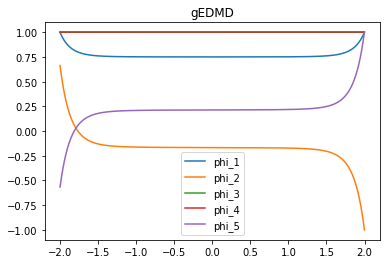

In [74]:
from d3s.tools import printVector, printMatrix
evs = 5 # number of eigenvalues/eigenfunctions to be computed
K1, d1, V1 = algorithms.gedmd(X, Y, Z, psi, evs=evs, operator='K')
printMatrix(K1, 'K_gEDMD')
printVector(np.real(d1), 'd_gEDMD')
R1 = V1.T @ PsiC
for i in range(evs):
    R1[i, :] = R1[i, :]/np.amax(abs(R1[i, :]))
plt.figure(1)
plt.clf()
plt.plot(c.T, R1.T)
plt.title('gEDMD')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

K_self_gEDMD = 
  (columns 0 through 7)
     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
     0.00000    -0.99897    -0.00006    -0.00888     0.00019     0.02045    -0.00015    -0.01468
     0.49948    -0.00005    -1.98482     0.00026    -0.07200    -0.00038     0.11578     0.00019
     0.00001     1.47182     0.00048    -2.75418    -0.00198    -0.57759     0.00163     0.44609
     0.00564     0.00056     2.83485    -0.00265    -3.20534     0.00386    -1.31784    -0.00177
    -0.00010     0.14664    -0.00162     3.70096     0.00693    -1.84972    -0.00383    -2.69245
    -0.02065    -0.00175     0.61181     0.00704     4.49211    -0.00794    -0.77351     0.00219
     0.00023    -0.31750     0.00273     2.90371    -0.01117     3.01869     0.00247     0.52134
     0.03317     0.00225    -1.01320    -0.00610     5.23841     0.00026     3.96046     0.00535
    -0.00011     0.21561    -0.00125    -2.28863     0.00421     7.37592     0.00232   

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


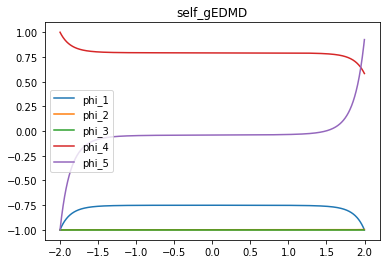

In [75]:
K = gEDMD(X, Y, Z, psi)
d, V = sortEig(K, evs=evs, which='SM')
printMatrix(K, 'K_self_gEDMD')
printVector(np.real(d), 'd_self_gEDMD')
R = V.T @ PsiC
for i in range(evs):
    R[i, :] = R[i, :]/np.amax(abs(R[i, :]))
plt.figure(1)
plt.clf()
plt.plot(c.T, R.T)
plt.title('self_gEDMD')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

K__online_gEDMD = 
  (columns 0 through 7)
     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
     0.00001    -0.99891    -0.00023    -0.00939     0.00103     0.02163    -0.00152    -0.01554
     0.49949    -0.00011    -1.98520     0.00068    -0.07042    -0.00100     0.11377    -0.00031
    -0.00006     1.47159     0.00260    -2.75215    -0.01157    -0.58265     0.01592     0.45071
     0.00555     0.00145     2.83726    -0.00979    -3.21580     0.01780    -1.30392    -0.00535
     0.00009     0.14634    -0.00663     3.70317     0.02809    -1.85307    -0.03348    -2.69414
    -0.02046    -0.00381     0.60679     0.02354     4.51359    -0.04111    -0.80199     0.01433
     0.00010    -0.31636     0.00507     2.89446    -0.01768     3.03806     0.00692     0.51114
     0.03314     0.00228    -1.01261    -0.00597     5.23719     0.00000     3.96079     0.00349
    -0.00030     0.21654     0.00473    -2.29640    -0.02562     7.39141     0.05019

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


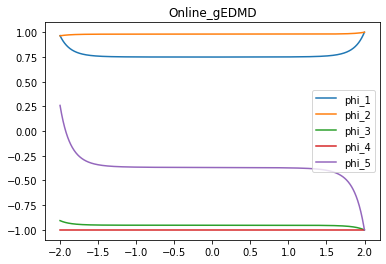

In [76]:
PsiX = psi(X)
dPsiY = np.einsum('ijk,jk->ik', psi.diff(X), Y)
if not (Z is None): # stochastic dynamical system
    n = PsiX.shape[0] # number of basis functions
    ddPsiX = psi.ddiff(X) # secplond-order derivatives
    S = np.einsum('ijk,ljk->ilk', Z, Z) # sigma \cdot sigma^T
    for i in range(n):
        dPsiY[i, :] += 0.5*np.sum( ddPsiX[i, :, :, :] * S, axis=(0,1) )
            
init_size = 500
X_base = PsiX[:, :init_size]
Y_base = dPsiY[:, :init_size]
G = np.linalg.pinv(X_base @ X_base.T)
K_o, d_o, V_o = edmd(X_base, Y_base, psi,evs=evs)
for i in range(m-init_size):
    X_add = PsiX[:, init_size+i].reshape(-1,1)
    Y_add = dPsiY[:, init_size+i].reshape(-1,1)
    K_o, G = online_EDMD(K_o, G, X_add, Y_add)
d_o, V_o = sortEig(K_o, evs=evs)

printMatrix(K_o, 'K__online_gEDMD')
printVector(np.real(d_o), 'd_Online_gEDMD')
R_o = V_o.T @ PsiC
for i in range(evs):
    R_o[i, :] = R_o[i, :]/np.amax(abs(R_o[i, :]))
plt.figure(1)
plt.clf()
plt.plot(c.T, R_o.T)
plt.title('Online_gEDMD')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

K_gEDMD = 
  (columns 0 through 7)
     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
     0.00000    -0.99890    -0.00021    -0.00944     0.00109     0.02168    -0.00155    -0.01551
     0.49953    -0.00014    -1.98509     0.00060    -0.07091    -0.00089     0.11388    -0.00025
     0.00014     1.47138     0.00145    -2.75169    -0.01150    -0.58341     0.01641     0.45031
     0.00515     0.00173     2.83602    -0.00879    -3.21045     0.01653    -1.30523    -0.00617
    -0.00098     0.14728    -0.00009     3.70122     0.02625    -1.84938    -0.03578    -2.69232
    -0.01896    -0.00491     0.61066     0.02069     4.49580    -0.03717    -0.79766     0.01680
     0.00246    -0.31791    -0.01063     2.89757    -0.00991     3.03051     0.01121     0.50781
     0.03073     0.00331    -1.01845     0.00158     5.26477    -0.00932     3.95345    -0.00252
    -0.00207     0.21601     0.02054    -2.29466    -0.04262     7.39500     0.04909     7.0

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


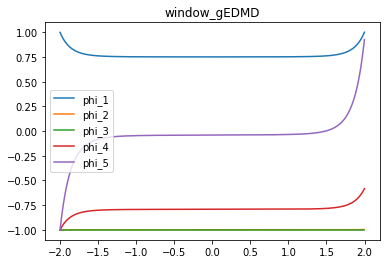

In [77]:
init_size = 500
X_base = PsiX[:, :init_size]
Y_base = dPsiY[:, :init_size]
G = np.linalg.pinv(X_base @ X_base.T)
C_inv = np.linalg.inv(np.array([[-1, 0],[0, 1]]))
K_w, d_w, V_w = edmd(X_base, Y_base, psi,evs=evs)
w=init_size
for i in range(m-init_size-1):
    U = np.array([PsiX[:, i], PsiX[:, w+i]]).T
    V = np.array([dPsiY[:, i], dPsiY[:, w+i]]).T
    K_w, G = window_update(K_w, G, U, V, C_inv)
d_w, V_w = sortEig(K, evs=evs)

printMatrix(K_w, 'K_gEDMD')
printVector(np.real(d_w), 'd_gEDMD')

R_w = V_w.T @ PsiC
for i in range(evs):
    R_w[i, :] = R_w[i, :]/np.amax(abs(R_w[i, :]))
plt.figure(1)
plt.clf()
plt.plot(c.T, R_w.T)
plt.title('window_gEDMD')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

In [80]:
#クープマン行列の誤差
print(np.max(np.abs(K1[:10,:10])) - np.max(np.abs(K[:10,:10])))
print(np.max(np.abs(K1)) - np.max(np.abs(K_o)))
print(np.max(np.abs(K1)) - np.max(np.abs(K_w)))
print("---------")
print(np.max(np.abs(K)) - np.max(np.abs(K)))
print(np.max(np.abs(K)) - np.max(np.abs(K_o)))
print(np.max(np.abs(K)) - np.max(np.abs(K_w)))

1.921672965643495e-06
0.0052144460051266606
-0.3962087454557093
---------
0.0
0.0061868012183907695
-0.39523639024244517
